# Importing the required libs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import pandas_datareader.data as pdr
from datetime import datetime

In [3]:
from statsmodels.tsa.stattools import coint
from statsmodels.api import OLS

# Defining the stock universe. In this case we use Bank Nifty stocks

In [4]:
tickers = ["HDFC.NS","HDFCBANK.NS","ICICIBANK.NS","YESBANK.NS","KOTAKBANK.NS","AXISBANK.NS","SBIN.NS","IDFC.NS","BAJAJFINSV.NS"]

Importing data from 2012 to current day

In [5]:
start= datetime(2012,1,1)
end = datetime.today()

ohlc_daily = {}


for i in range(len(tickers)):
    ohlc_daily[tickers[i]] = pdr.get_data_yahoo(tickers[i],start = start , end = end)

# Dividing dataset to training and test phase

In [6]:
train_limit=1400
ohlc_daily_train = {}
for ticker in tickers:
    ohlc_daily_train[ticker] = ohlc_daily[ticker][:train_limit] 

ohlc_daily_test = {}
for ticker in tickers:
    ohlc_daily_test[ticker] = ohlc_daily[ticker][train_limit:]

In [7]:
train_database = pd.DataFrame()
for ticker in tickers:
    train_database = pd.concat([train_database,ohlc_daily_train[ticker]['Adj Close']],axis = 1) 
train_database.columns = tickers
train_database.dropna(inplace = True)

In [8]:
train_database.tail()

,HDFC.NS,HDFCBANK.NS,ICICIBANK.NS,YESBANK.NS,KOTAKBANK.NS,AXISBANK.NS,SBIN.NS,IDFC.NS,BAJAJFINSV.NS
2017-09-04 00:00:00,1671.210083,862.600769,291.086151,340.682617,977.074341,501.127655,277.750000,52.669125,5370.920898
2017-09-05 00:00:00,1682.539551,864.793091,291.576019,343.415253,987.363586,502.775604,276.549988,53.390617,5389.548828
2017-09-06 00:00:00,1689.870117,867.034851,289.371582,346.447266,995.105408,492.238678,274.250000,54.337582,5449.727539
2017-09-07 00:00:00,1696.248657,870.310974,286.726227,347.615601,992.458191,495.984039,274.200012,54.292484,5617.180664
2017-09-08 00:00:00,1693.821167,880.706116,286.089386,345.491302,1006.493408,493.387268,271.799988,53.165150,5588.165039


In [9]:
test_database = pd.DataFrame()
for ticker in tickers:
    test_database = pd.concat([test_database,ohlc_daily_test[ticker]['Adj Close']],axis = 1) 
test_database.columns = tickers
test_database.dropna(inplace = True)

# Running the stationarity test and choosing pairs having t-score < 3

In [10]:
def find_cointegrated_pairs(data,t_score):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            score_matrix[i, j] = score
            if score < t_score :
                pairs.append((keys[i], keys[j]))
    return score_matrix,pairs

scores, pairs = find_cointegrated_pairs(train_database,t_score=-3)
scores

array([[ 0.        , -2.39334581, -0.24554973, -3.11269581, -1.60465792,
         0.32848179, -0.15406879, -0.03458631, -2.86782542],
       [ 0.        ,  0.        ,  0.22927127, -3.09639176, -1.71305417,
         1.85350216, -0.34770095,  1.82602763, -2.29029846],
       [ 0.        ,  0.        ,  0.        , -1.78673328, -1.64798427,
        -2.09131882, -4.48637569, -0.95320772, -1.68068448],
       [ 0.        ,  0.        ,  0.        ,  0.        , -1.84061614,
         1.73103712, -0.16852666,  1.32161422, -2.27640866],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.12490243, -1.40214643,  0.61459943, -1.70028511],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -2.52941886, -1.0532518 , -1.10818252],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -1.346585  , -1.85882821],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

# Creating spread and using regression on train data to determine hedge ratio

In [11]:
model = OLS(train_database['HDFC.NS'], train_database['KOTAKBANK.NS'])
model = model.fit()



df = pd.DataFrame()
df['HDFC'] = test_database['HDFC.NS']
df['KOTAKBANK'] = test_database['KOTAKBANK.NS']
df['spread'] = df['HDFC']- model.params[0]*df['KOTAKBANK']
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                HDFC.NS   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                          3.651e+04
Date:                Mon, 03 Aug 2020   Prob (F-statistic):                        0.00
Time:                        01:08:09   Log-Likelihood:                         -9241.5
No. Observations:                1400   AIC:                                  1.848e+04
Df Residuals:                    1399   BIC:                                  1.849e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
KOTAKBANK.NS     1.5458      0.008    191.064      0.000       1.530       1.562
==============================================================================
Omnibus:                      163.407   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.352
Skew:                          -0.943   Prob(JB):                     2.84e-47
Kurtosis:                       2.654   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Creating the features required for a Pairs Trading Strategy.

In [24]:
df['mean']  = df['spread'].rolling(20).mean()
df['z_score'] = (df['spread']-df['mean'])/df['spread'].rolling(20).std()



df.dropna(inplace=True)

entry_threshold = 2 

df['Long_Entry']=0
df['Long_Exit']=0

df['Short_Entry']=0
df['Short_Exit']=0

# Creating the Pairs Trading strategy. Positions are taken whenever the spread's z-core has crossed the entry threshold and reversed. Exiting the trade when z-score crosses 0

In [25]:
def Pairs_Trading(df,hedge_ratio):
    signal = 0 
    long_ret = []
    short_ret = [] 
    ret = []
    
    for i in range(len(df)):
        
        if (signal== 0):
            ret.append(0)
            long_ret.append(0)
            short_ret.append(0)

            #Long_Entry:
            
            if(df['z_score'][i] < - entry_threshold
               and df['z_score'][i-1] < df['z_score'][i]
               and df['z_score'][i-1] < df['z_score'][i-2]):
                signal = 1
                df["Long_Entry"][i] = df["HDFC"][i]
                df['Short_Entry'][i] = df['KOTAKBANK'][i]
            
            #Short_Entry:
            elif(df['z_score'][i-1] > entry_threshold
               and df['z_score'][i-1] > df['z_score'][i]
               and df['z_score'][i-1] > df['z_score'][i-2]):
                signal = -1
                df["Long_Entry"][i] = df["KOTAKBANK"][i]
                df['Short_Entry'][i] = df['HDFC'][i]
            
                       
            #Long_Exit
        elif (signal == 1):
                if(df['z_score'][i] > 0
                   and df['z_score'][i-1] < 0):
                    signal = 0
                    df['Long_Exit'][i] = df['HDFC'][i]
                    df['Short_Exit'][i] = df['KOTAKBANK'][i]
                    long_ret.append((df['HDFC'][i]/df['HDFC'][i-1]-1))
                    short_ret.append(hedge_ratio*(1-df['KOTAKBANK'][i]/df['KOTAKBANK'][i-1]))
                else:
                    long_ret.append((df['HDFC'][i]/df['HDFC'][i-1]-1))
                    short_ret.append(hedge_ratio*(1-df['KOTAKBANK'][i]/df['KOTAKBANK'][i-1]))
            
             #Short_Exit
        elif (signal == -1):
                if(df['z_score'][i] < 0 
                   and df['z_score'][i-1] > 0):
                    signal = 0
                    df['Long_Exit'][i] = df['KOTAKBANK'][i]
                    df['Short_Exit'][i] = df['HDFC'][i]    
                    long_ret.append(hedge_ratio*(df['KOTAKBANK'][i]/df['KOTAKBANK'][i-1]-1))
                    short_ret.append((1-df['HDFC'][i]/df['HDFC'][i-1]))
                else:
                    long_ret.append(hedge_ratio*(df['KOTAKBANK'][i]/df['KOTAKBANK'][i-1]-1))
                    short_ret.append((1-df['HDFC'][i]/df['HDFC'][i-1]))

      
                    
                    
    df['Long_ret'] = np.array(long_ret)
    df['Short_ret'] = np.array(short_ret)
    df['ret'] = df['Long_ret'] + df['Short_ret']



                    
    return df

# Running the strategy on the selected pairs

In [26]:
df2 = df.copy()
df3 = Pairs_Trading(df2,hedge_ratio = model.params[0])

C:\Users\av228\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\av228\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\av228\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\av228\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value i

# Performance analysis function to determine strategy's performance using different metrics

In [27]:
def performance_analysis(df,window,rf,leverage):    
    
    df['cum_return'] = (1+df['ret']*leverage).cumprod()
    Cumm_Ret = (df['cum_return'][-1]-1)
    
    n = len(df)/(252)   
    CAGR = ((df["cum_return"][-1])**(1/n) - 1)
    
    df['rolling_volatility'] = df['ret'].rolling(window).std()
    volatility =  df['ret'].std()*np.sqrt(252)
    
    df['rolling_sharpe'] = df['ret'].rolling(window).mean()/df['ret'].rolling(window).std()*np.sqrt(window)
    sr = (CAGR - rf)/volatility
    
  
    
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    
    df["Year"] = df.index.map(lambda x: x.year)
    df["Month"] = df.index.map(lambda x: x.strftime("%b"))
    pt = df.pivot_table(index="Month",columns="Year",values="ret", aggfunc="sum").fillna(0)
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    pt = pt.reindex(months)    
    sns.heatmap(pt, annot=True, cmap="RdYlGn")
    
    performance_df = pd.DataFrame([Cumm_Ret*100,CAGR*100,volatility,sr,max_dd*100],index=["Cumm_Return","Annual_Return","Volatility","Sharpe Ratio","Max Drawdown"])      
    print(performance_df)

    return df


                       0
Cumm_Return    52.188232
Annual_Return  19.465842
Volatility      0.153100
Sharpe Ratio    1.108154
Max Drawdown    8.584825


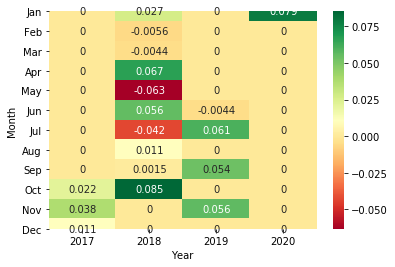

In [29]:
portfolio = performance_analysis(df3,window=20,rf=0.025,leverage=1)

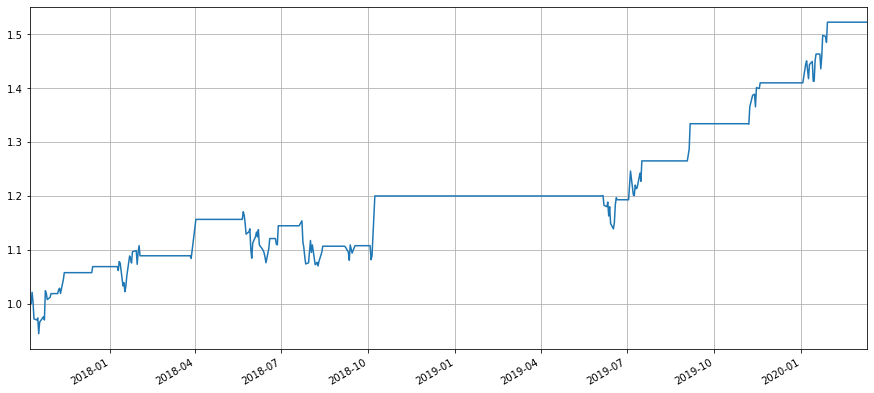

In [30]:
portfolio['cum_return'].plot(figsize=(15,7),grid=True)

In [16]:
portfolio.to_csv("HDFC_KOTAK.csv")